In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/Data Description/archive.zip'

# Create the target directory if it doesn't exist
target_dir = '/content/data/'
os.makedirs(target_dir, exist_ok=True)

# Unzip the file to the target directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

In [ ]:
! pip install antspyx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


# Data Preparation

## Analyzing Data

In [ ]:
# To load a NIfti file, we can use the load() function from the nibabel librairy :
import nibabel as nib
patient_path = '/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
t1 = nib.load(patient_path).get_fdata()

In [ ]:
# To prints the 3D array dimensions, we use the shape function :
t1.shape

(240, 240, 155)

In [ ]:
import numpy as np
# To check the intensity range (minimum/maximum pixel values) for a modality
print(f"  T1: {np.min(t1)} - {np.max(t1)}")

  T1: 0.0 - 678.0


In [ ]:
# For the segmentation mask, we can check the labels in it
# We can use the unique() function to extracts all unique integer values present in the 3D segmentation array
seg = nib.load("/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()
# Here, we can set the "return_counts" argument to True, this will make the function return a second array counting how many voxels belong to each label
unique_labels, counts = np.unique(seg, return_counts=True)
unique_labels

array([0., 1., 2., 4.])

This means we have 4 labels : 0, 1, 2, and 4.

Based on the output, the BraTS2020 segmentation masks use integer labels (0, 1, 2, 4) and are not one-hot encoded..

In [ ]:
counts

array([8716021,   15443,  168794,   27742])

In [ ]:
# We can calculate statistics about the distribution of different labels in the segmentation mask
# First, we will iterates through each label and its count, zip(unique_labels, counts) will pairs each label with its corresponding voxel count
for label, count in zip(unique_labels, counts):
    print(f"  Label {label}: {count} voxels ({count/np.prod(seg.shape)*100:.2f}%)")

  Label 0.0: 8716021 voxels (97.63%)
  Label 1.0: 15443 voxels (0.17%)
  Label 2.0: 168794 voxels (1.89%)
  Label 4.0: 27742 voxels (0.31%)



Patient: BraTS20_Training_350
Image shape: (240, 240, 155)
Voxel intensity ranges:
  T1: 0.0 - 6454.0
  T1ce: 0.0 - 13770.0
  T2: 0.0 - 6427.0
  FLAIR: 0.0 - 2348.0
Segmentation labels:
  Label 0.0: 8820325 voxels (98.79%)
  Label 1.0: 10403 voxels (0.12%)
  Label 2.0: 58299 voxels (0.65%)
  Label 4.0: 38973 voxels (0.44%)


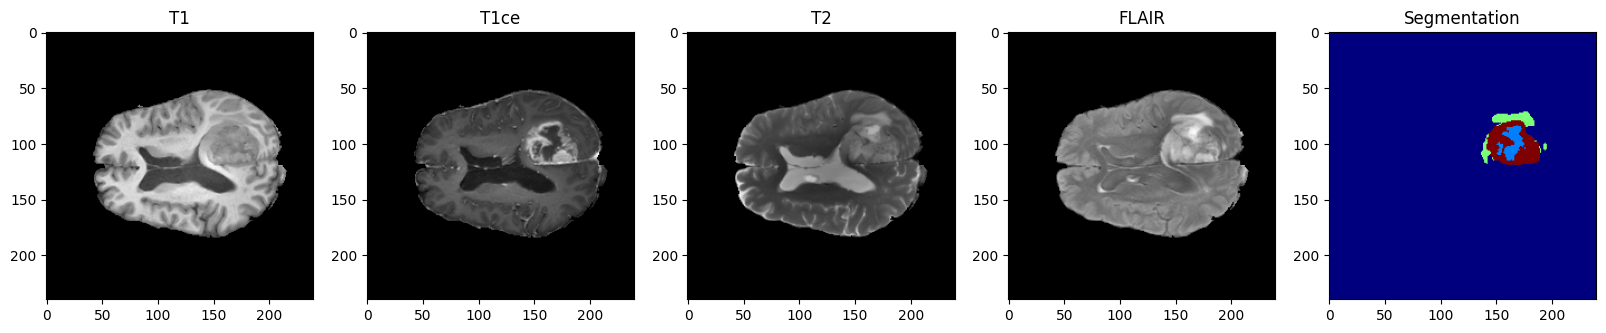


Patient: BraTS20_Training_047
Image shape: (240, 240, 155)
Voxel intensity ranges:
  T1: 0.0 - 702.0
  T1ce: 0.0 - 1784.0
  T2: 0.0 - 1628.0
  FLAIR: 0.0 - 776.0
Segmentation labels:
  Label 0.0: 8795318 voxels (98.51%)
  Label 1.0: 30245 voxels (0.34%)
  Label 2.0: 70436 voxels (0.79%)
  Label 4.0: 32001 voxels (0.36%)


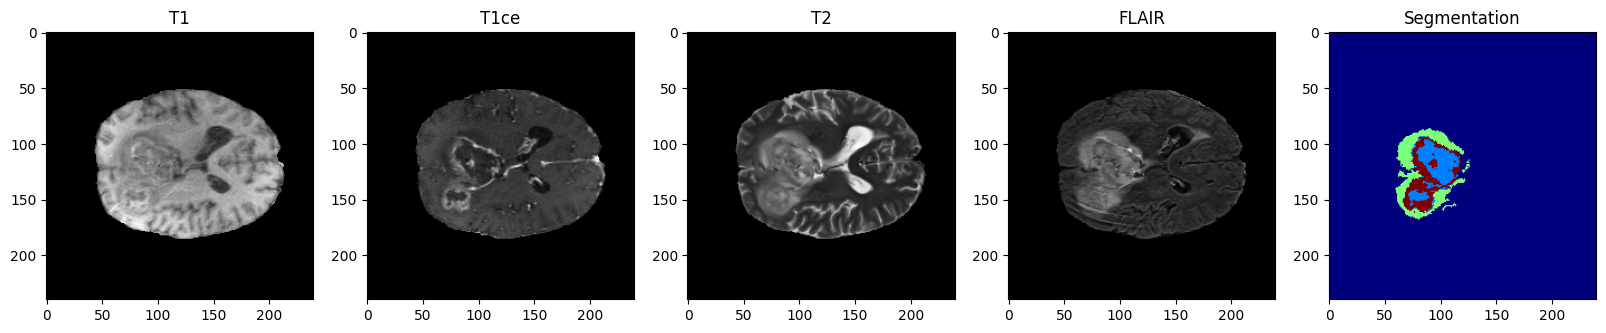


Patient: BraTS20_Training_100
Image shape: (240, 240, 155)
Voxel intensity ranges:
  T1: 0.0 - 734.0
  T1ce: 0.0 - 1744.0
  T2: 0.0 - 1695.0
  FLAIR: 0.0 - 911.0
Segmentation labels:
  Label 0.0: 8792748 voxels (98.49%)
  Label 1.0: 47184 voxels (0.53%)
  Label 2.0: 58053 voxels (0.65%)
  Label 4.0: 30015 voxels (0.34%)


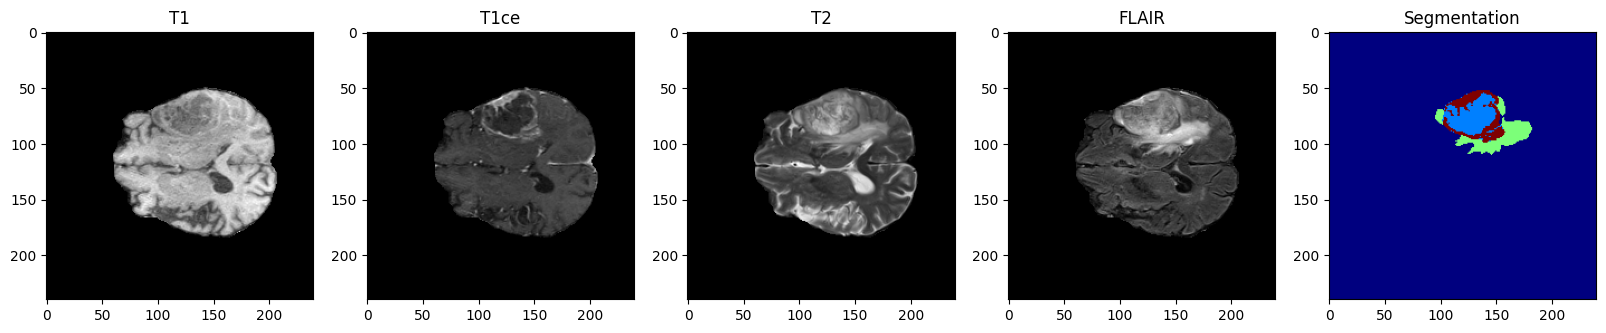

In [ ]:
# Now we can merge all of this in one function : analyze_data
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
patient_folders = [f for f in os.listdir(base_path) if f.startswith("BraTS20_Training_")]

def analyze_data(patient_path):

    # Load all modalities
    t1 = nib.load(os.path.join(patient_path, f"{os.path.basename(patient_path)}_t1.nii")).get_fdata()
    t1ce = nib.load(os.path.join(patient_path, f"{os.path.basename(patient_path)}_t1ce.nii")).get_fdata()
    t2 = nib.load(os.path.join(patient_path, f"{os.path.basename(patient_path)}_t2.nii")).get_fdata()
    flair = nib.load(os.path.join(patient_path, f"{os.path.basename(patient_path)}_flair.nii")).get_fdata()
    seg = nib.load(os.path.join(patient_path, f"{os.path.basename(patient_path)}_seg.nii")).get_fdata()

    # Statistics
    print(f"\nPatient: {os.path.basename(patient_path)}")
    print(f"Image shape: {t1.shape}")
    print(f"Voxel intensity ranges:")
    print(f"  T1: {np.min(t1)} - {np.max(t1)}")
    print(f"  T1ce: {np.min(t1ce)} - {np.max(t1ce)}")
    print(f"  T2: {np.min(t2)} - {np.max(t2)}")
    print(f"  FLAIR: {np.min(flair)} - {np.max(flair)}")

    # Label analysis
    unique_labels, counts = np.unique(seg, return_counts=True)
    print("Segmentation labels:")
    for label, count in zip(unique_labels, counts):
        print(f"  Label {label}: {count} voxels ({count/np.prod(seg.shape)*100:.2f}%)")

    # Visualize a middle slice
    slice_idx = t1.shape[2] // 2
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow(t1[:, :, slice_idx], cmap='gray')
    axes[0].set_title('T1')
    axes[1].imshow(t1ce[:, :, slice_idx], cmap='gray')
    axes[1].set_title('T1ce')
    axes[2].imshow(t2[:, :, slice_idx], cmap='gray')
    axes[2].set_title('T2')
    axes[3].imshow(flair[:, :, slice_idx], cmap='gray')
    axes[3].set_title('FLAIR')
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet')
    axes[4].set_title('Segmentation')
    plt.show()

# Analyze first few patients
for folder in patient_folders[:3]:
    analyze_data(os.path.join(base_path, folder))

### How many patients in the training Data

In [ ]:
import os

base_path = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
patient_folders = [f for f in os.listdir(base_path) if f.startswith("BraTS20_Training_")]

num_patients = len(patient_folders)
print(f"Total number of patients: {num_patients}")

min_num = min(int(f.split('_')[-1]) for f in patient_folders)
max_num = max(int(f.split('_')[-1]) for f in patient_folders)
print(f"Patient IDs range from {min_num:03d} to {max_num:03d}")

Total number of patients: 369
Patient IDs range from 001 to 369


### Checking Folder Contents :
### To verify that all patient folders have the same structure and required files:


In [ ]:
required_files = ['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii', '_seg.nii']

for folder in patient_folders:
    folder_path = os.path.join(base_path, folder)
    files = os.listdir(folder_path)

    # Check file count
    if len(files) != 5:
        print(f"Folder {folder} has {len(files)} files instead of 5")

    # Check required modalities
    for suffix in required_files:
        if not any(f.endswith(suffix) for f in files):
            print(f"Folder {folder} is missing file with {suffix}")

Folder BraTS20_Training_355 is missing file with _seg.nii


### We have a missing segmented tumor for the 355 folder, let's first check this folder's content

In [ ]:
import os

# Define the base path and specific folder to check
base_path = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
folder_to_check = "BraTS20_Training_355"
folder_path = os.path.join(base_path, folder_to_check)

# Check if the folder exists
if not os.path.exists(folder_path):
    print(f"Folder {folder_to_check} does not exist in the dataset.")
else:
    # List all files in the folder
    files = os.listdir(folder_path)
    print(f"Contents of {folder_to_check}:")
    for file in files:
        print(f"  - {file}")

    # Check for the segmentation file
    seg_file = f"{folder_to_check}_seg.nii"
    if seg_file not in files:
        print(f"\nWARNING: Segmentation file '{seg_file}' is missing in {folder_to_check}!")
    else:
        print(f"\nSegmentation file '{seg_file}' is present.")

    # Check for all expected modalities
    expected_suffixes = ['_t1.nii', '_t1ce.nii', '_t2.nii', '_flair.nii', '_seg.nii']
    missing_files = [suffix for suffix in expected_suffixes
                   if not any(file.endswith(suffix) for file in files)]

    if missing_files:
        print("\nMissing files:")
        for suffix in missing_files:
            print(f"  - {folder_to_check}{suffix}")
    else:
        print("\nAll expected files are present.")

Contents of BraTS20_Training_355:
  - BraTS20_Training_355_t1.nii
  - BraTS20_Training_355_t1ce.nii
  - W39_1998.09.19_Segm.nii
  - BraTS20_Training_355_t2.nii
  - BraTS20_Training_355_flair.nii


Missing files:
  - BraTS20_Training_355_seg.nii


### The segmentation file "W39_1998.09.19_Segm.nii" has an inconsistent naming convention in this folder.

### We should change its name from 'W39_1998.09.19_Segm.nii' to 'BraTS20_Training_355_seg.nii'

In [ ]:
import os

# Define paths
base_path = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
folder_name = "BraTS20_Training_355"
folder_path = os.path.join(base_path, folder_name)
old_seg_name = "W39_1998.09.19_Segm.nii"
correct_seg_name = f"{folder_name}_seg.nii"

old_seg_path = os.path.join(folder_path, old_seg_name)
correct_seg_path = os.path.join(folder_path, correct_seg_name)

# Renameing
os.rename(old_seg_path, correct_seg_path)
print(f"Successfully renamed:\n{old_seg_name} -> {correct_seg_name}")

# Verify the folder now has all expected files
expected_files = [
    f"{folder_name}_t1.nii",
    f"{folder_name}_t1ce.nii",
    f"{folder_name}_t2.nii",
    f"{folder_name}_flair.nii",
    correct_seg_name
]

print("\nFinal folder contents:")
missing_files = []
for f in os.listdir(folder_path):
    print(f" - {f}")
    if f in expected_files:
        expected_files.remove(f)


Successfully renamed:
W39_1998.09.19_Segm.nii -> BraTS20_Training_355_seg.nii

Final folder contents:
 - BraTS20_Training_355_t2.nii
 - BraTS20_Training_355_flair.nii
 - BraTS20_Training_355_t1ce.nii
 - BraTS20_Training_355_t1.nii
 - BraTS20_Training_355_seg.nii


## Data Visualization

### Visualize multiple slices in the T1 modality using AntsPy : Sagittal View

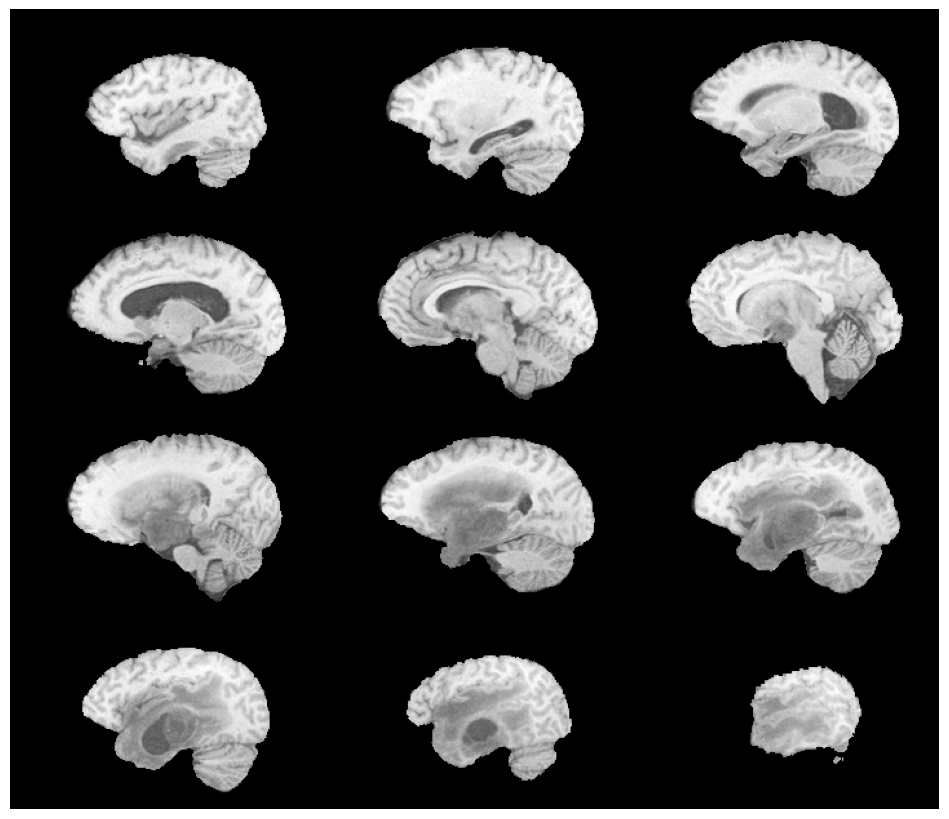

In [ ]:
import ants
img_path = '/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
img = ants.image_read(img_path)
ants.plot(img,figsize = 2 , axis = 0)

### Flair Modality : T2 **FL**uid **A**ttenuated **I**nversion **R**ecovery

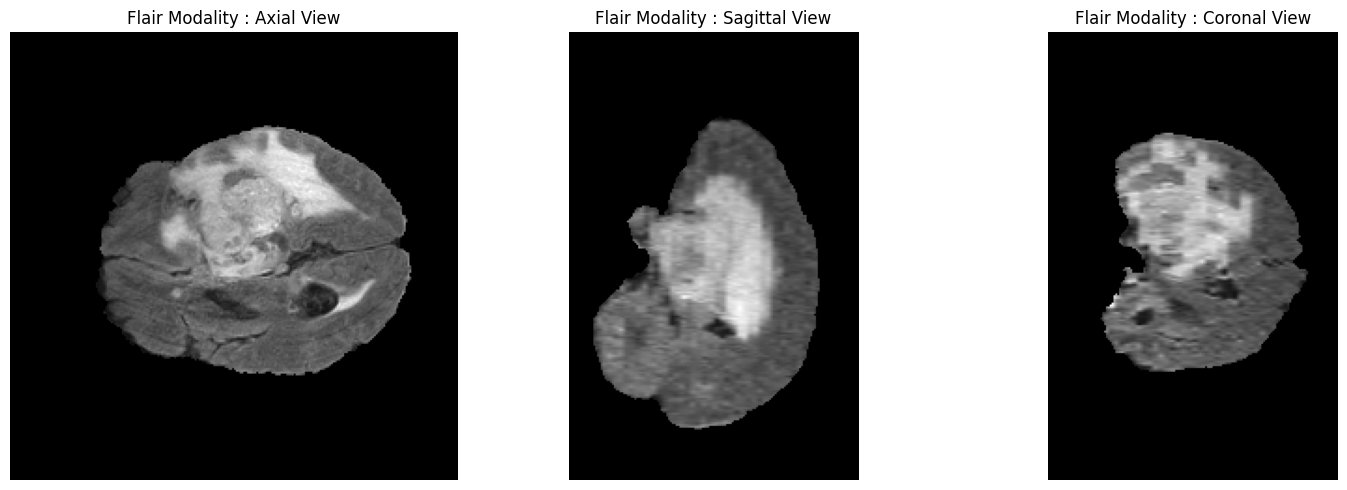

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

nifti_img = nib.load('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(nifti_img.get_fdata()[:, :, 70], cmap='gray')
axes[0].set_title('Flair Modality : Axial View')
axes[0].axis('off')

# Sagittal view
axes[1].imshow(nifti_img.get_fdata()[100, :, :], cmap='gray')
axes[1].set_title('Flair Modality : Sagittal View')
axes[1].axis('off')

# Coronal view
axes[2].imshow(nifti_img.get_fdata()[:, 120, :], cmap='gray')
axes[2].set_title('Flair Modality : Coronal View')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### T1 Modality : Native

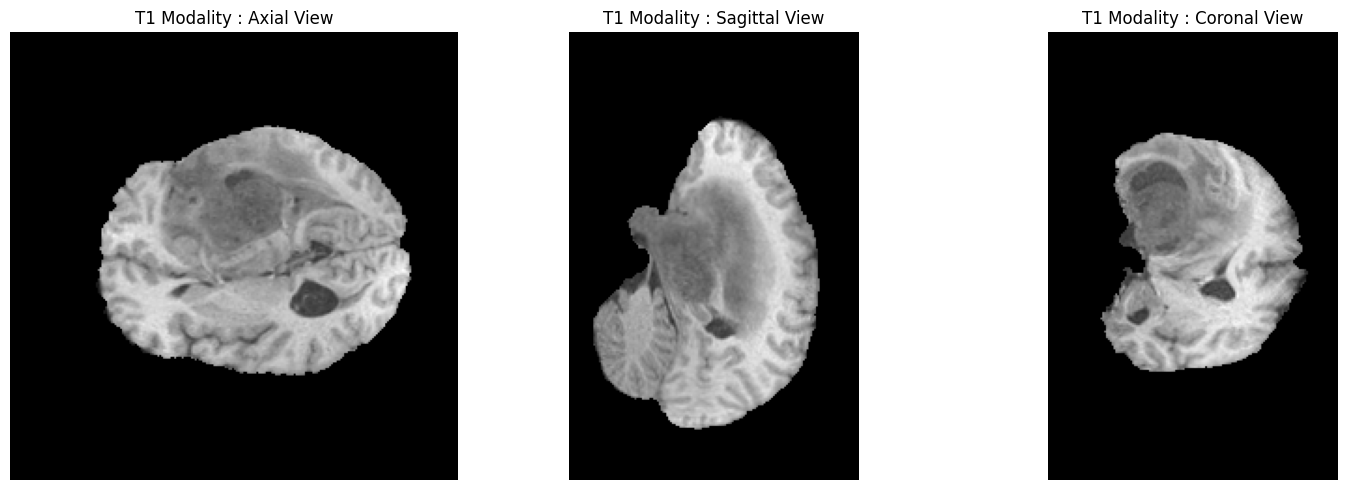

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

nifti_img = nib.load('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(nifti_img.get_fdata()[:, :, 70], cmap='gray')
axes[0].set_title('T1 Modality : Axial View')
axes[0].axis('off')

# Sagittal view
axes[1].imshow(nifti_img.get_fdata()[100, :, :], cmap='gray')
axes[1].set_title('T1 Modality : Sagittal View')
axes[1].axis('off')

# Coronal view
axes[2].imshow(nifti_img.get_fdata()[:, 120, :], cmap='gray')
axes[2].set_title('T1 Modality : Coronal View')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### T2 Modality : T2-weighted

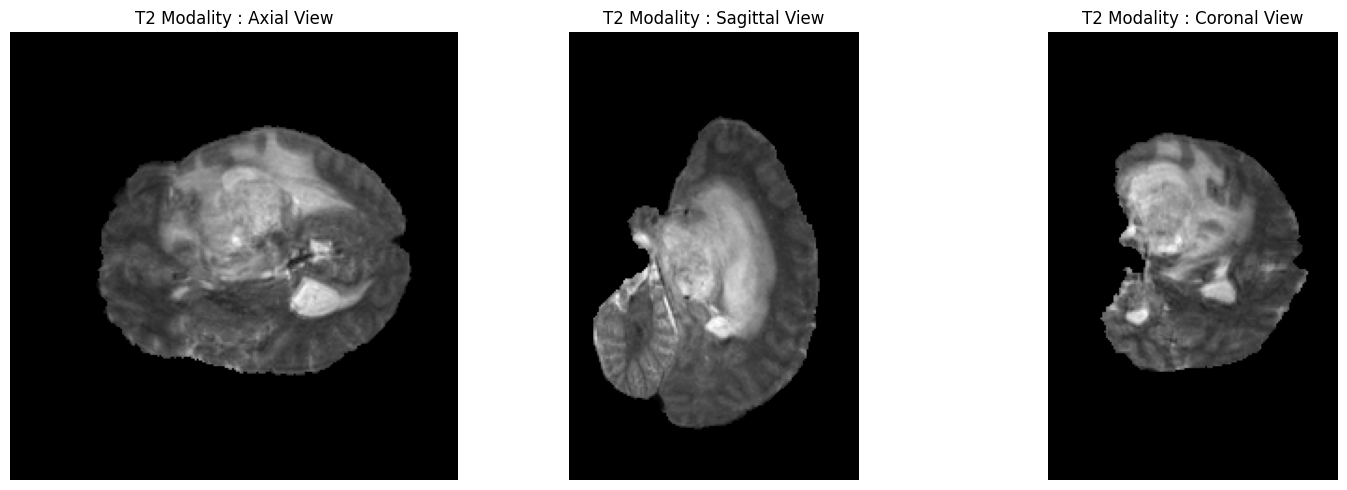

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

nifti_img = nib.load('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(nifti_img.get_fdata()[:, :, 70], cmap='gray')
axes[0].set_title('T2 Modality : Axial View')
axes[0].axis('off')

# Sagittal view
axes[1].imshow(nifti_img.get_fdata()[100, :, :], cmap='gray')
axes[1].set_title('T2 Modality : Sagittal View')
axes[1].axis('off')

# Coronal view
axes[2].imshow(nifti_img.get_fdata()[:, 120, :], cmap='gray')
axes[2].set_title('T2 Modality : Coronal View')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### T1CE Modality : Post-Contrast T1-weighted

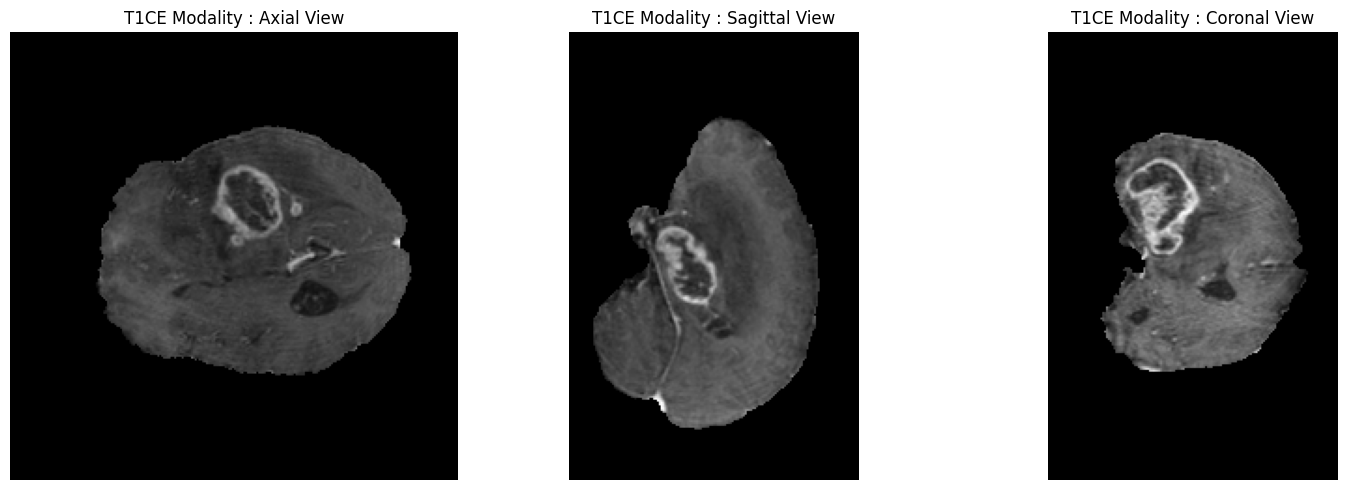

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

nifti_img = nib.load('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(nifti_img.get_fdata()[:, :, 70], cmap='gray')
axes[0].set_title('T1CE Modality : Axial View')
axes[0].axis('off')

# Sagittal view
axes[1].imshow(nifti_img.get_fdata()[100, :, :], cmap='gray')
axes[1].set_title('T1CE Modality : Sagittal View')
axes[1].axis('off')

# Coronal view
axes[2].imshow(nifti_img.get_fdata()[:, 120, :], cmap='gray')
axes[2].set_title('T1CE Modality : Coronal View')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Tumor Mask

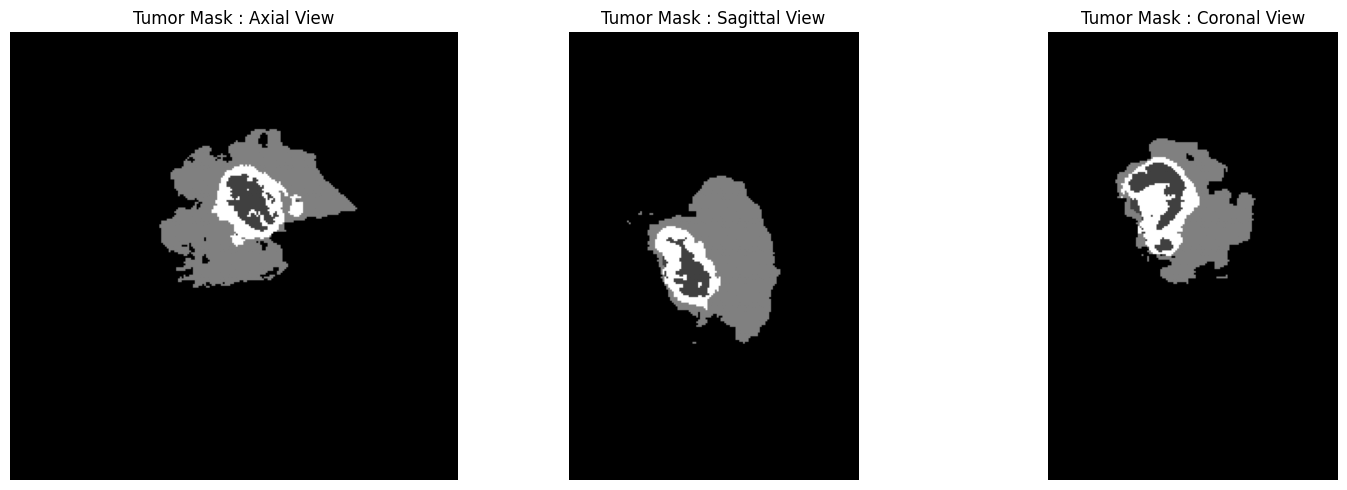

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

nifti_img = nib.load('/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axes[0].imshow(nifti_img.get_fdata()[:, :, 70], cmap='gray')
axes[0].set_title('Tumor Mask : Axial View')
axes[0].axis('off')

# Sagittal view
axes[1].imshow(nifti_img.get_fdata()[100, :, :], cmap='gray')
axes[1].set_title('Tumor Mask : Sagittal View')
axes[1].axis('off')

# Coronal view
axes[2].imshow(nifti_img.get_fdata()[:, 120, :], cmap='gray')
axes[2].set_title('Tumor Mask : Coronal View')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Bias Field Correction : Removing the Bias Field

### Using AntsPy : based on AnstPy documentation

In [ ]:
img_path = '/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
original_img = ants.image_read(img_path)

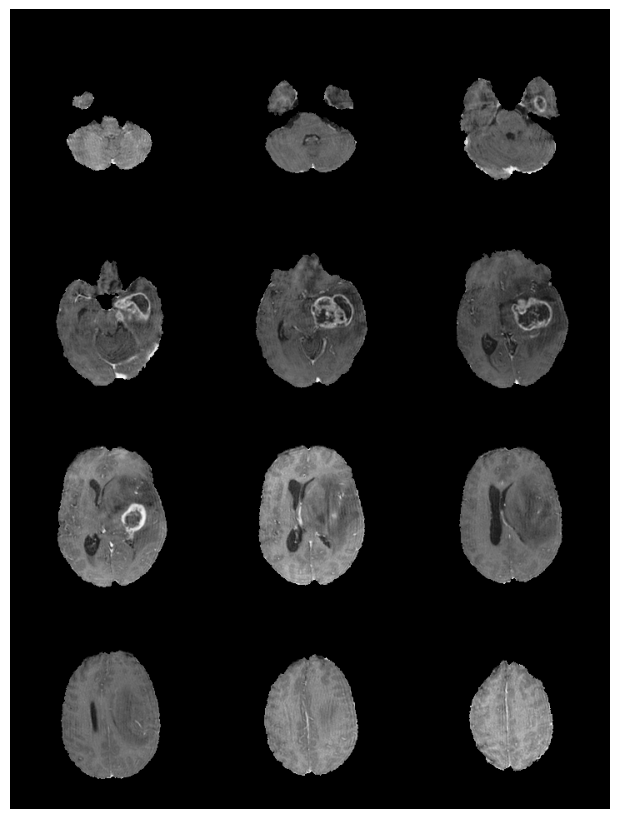

In [ ]:
ants.plot(original_img,figsize = 2 , axis = 2)

In [ ]:
# Create a mask
# We can use get_mask as it automatically generate a mask
mask = ants.get_mask(original_img)

In [ ]:
# Apply N4 Bias Field Correction
corrected_image = ants.n4_bias_field_correction(original_img, mask=mask, return_bias_field=False)

In [ ]:
# Extract the Bias Field by setting return_bias_field to True
bias_field = ants.n4_bias_field_correction(original_img, mask=mask, return_bias_field=True)

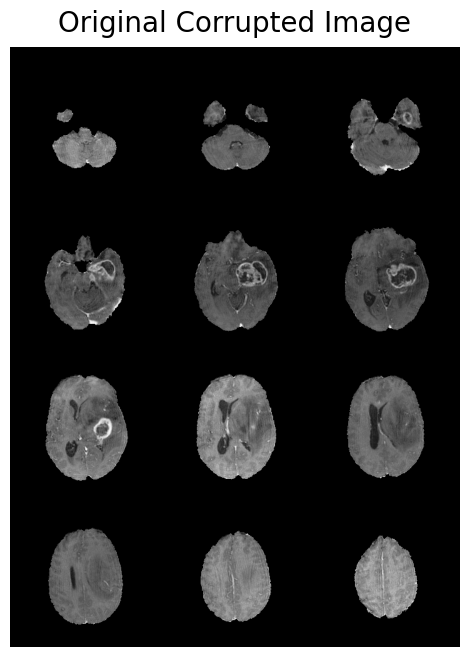

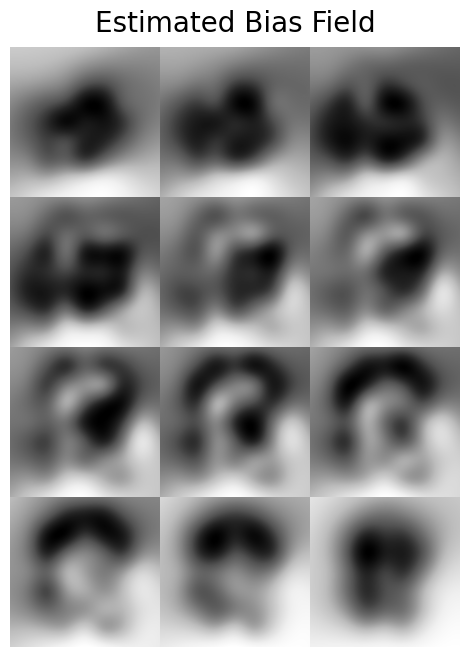

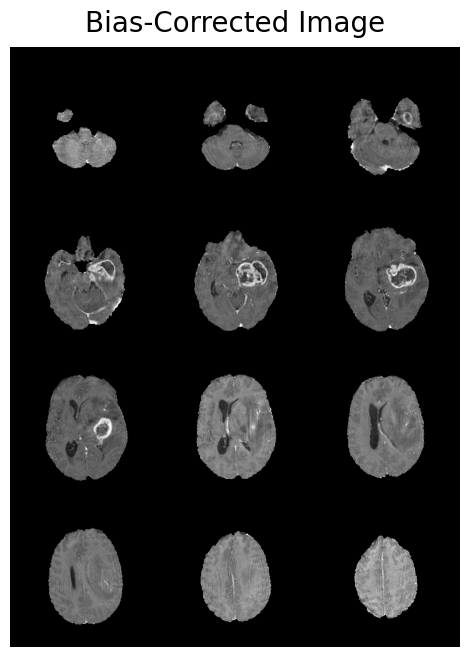

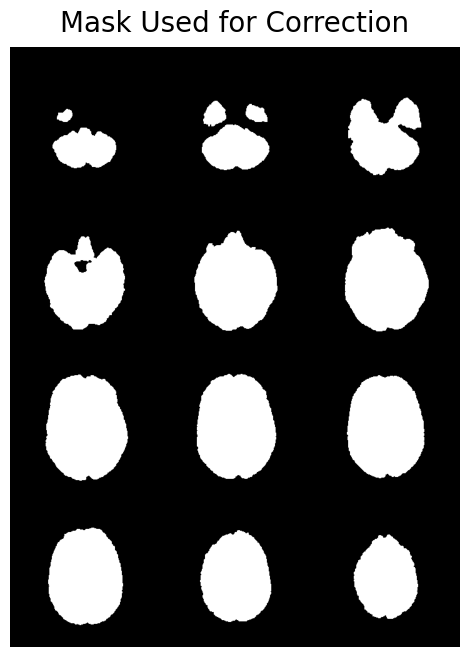

In [ ]:
# The axis parameter is set to 2 to visualize slices along the z-axis
ants.plot(original_img, axis=2, title="Original Corrupted Image_")
ants.plot(bias_field, axis=2, title="Estimated Bias Field")
ants.plot(corrected_image, axis=2, title="Bias-Corrected Image")
ants.plot(mask, axis=2, title="Mask Used for Correction")

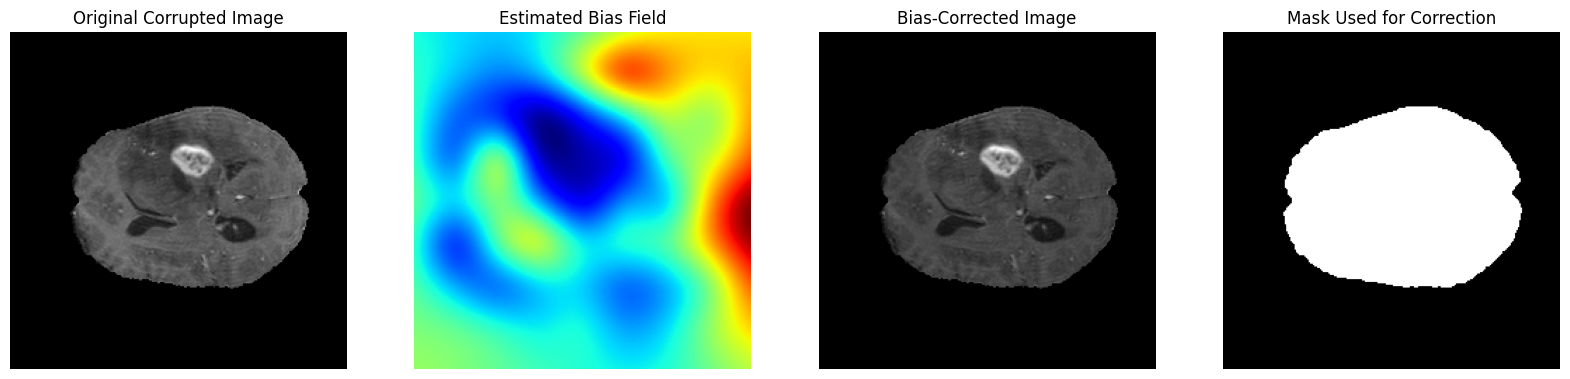

In [ ]:
import matplotlib.pyplot as plt

#View only a slice of the images

# Select a middle slice for visualization
# Get the middle slice index
slice_idx = original_img.shape[2] // 2
image_slice = original_img.numpy()[:, :, slice_idx]
bias_field_slice = bias_field.numpy()[:, :, slice_idx]
corrected_slice = corrected_image.numpy()[:, :, slice_idx]
mask_slice = mask.numpy()[:, :, slice_idx]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# original corrupted
axes[0].imshow(image_slice, cmap="gray")
axes[0].set_title("Original Corrupted Image")
axes[0].axis("off")

# Bias field
axes[1].imshow(bias_field_slice, cmap="jet")
axes[1].set_title("Estimated Bias Field")
axes[1].axis("off")

# Corrected image
axes[2].imshow(corrected_slice, cmap="gray")
axes[2].set_title("Bias-Corrected Image")
axes[2].axis("off")

# mask
axes[3].imshow(mask_slice, cmap="gray")
axes[3].set_title("Mask Used for Correction")
axes[3].axis("off")

plt.show()

### Apply on the whole dataset and save the results

In [ ]:
! pip install glob

In [ ]:
import os
import re
import glob
import ants
from tqdm import tqdm

def bias_field_correction(file_path):
    try:
        # Extract patient number and modality
        filename = os.path.basename(file_path)
        match = re.search(r"BraTS20_Training_(\d+)_(t1|t1ce|t2|flair|seg)\.nii", filename)
        if not match:
            print(f"Skipping {filename}: Invalid naming pattern")
            return None

        patient_num = match.group(1)
        modality = match.group(2)

        # Create new output directory
        original_dir = os.path.dirname(file_path)
        new_dir_path = os.path.join("/content/data_corrected", os.path.relpath(original_dir, start="/content/data"))
        os.makedirs(new_dir_path, exist_ok=True)

        # Load the img
        original_img = ants.image_read(file_path)

        # Create the mask
        mask = ants.get_mask(original_img)

        # Apply N4 correction
        corrected_img = ants.n4_bias_field_correction(
            original_img,
            mask=mask,
            return_bias_field=False
        )

        # Save corrected file in new location
        corrected_name = f"BraTS20_Training_corrected_{patient_num}_{modality}.nii"
        corrected_path = os.path.join(new_dir_path, corrected_name)
        ants.image_write(corrected_img, corrected_path)

        # Save mask in new location
        mask_name = f"BraTS20_Training_{patient_num}_Mask.nii"
        mask_path = os.path.join(new_dir_path, mask_name)
        ants.image_write(mask, mask_path)

        return corrected_path  # Return new path

    except Exception as e:
        print(f"ERROR processing {file_path}: {str(e)}")
        return None

path_to_original_imgs = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/**/*.nii"
all_files = list(glob.glob(path_to_original_imgs, recursive=True))

for patient_img_path in tqdm(all_files, desc="Bias Correction", unit="file"):
    result = bias_field_correction(patient_img_path)

#for i, patient_img_path in enumerate(glob.glob(path_to_original_imgs, recursive=True)):
#    result = bias_field_correction(patient_img_path)

#    if result:
#        print(f"{patient_img_path} : corrected : {result}")
#    else:
#        print(f"{patient_img_path} : failed")

print("Done")

## Normalization

First, we are going to load all the .nii.gz files

In [ ]:
! pip install glob

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Load a single test image
test_img_path = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii"
original_img = nib.load(test_img_path)
original_data = original_img.get_fdata()

# Print original image stats
print("BEFORE NORMALIZATION")
print(f"Original image shape: {original_data.shape}")
print(f"Min value: {np.min(original_data):.2f}")
print(f"Max value: {np.max(original_data):.2f}")
print(f"Mean: {np.mean(original_data):.2f}")
print(f"Standard deviation: {np.std(original_data):.2f}")

# Apply Z-score normalization
mean_val = np.mean(original_data)
std_val = np.std(original_data)
normalized_data = (original_data - mean_val) / std_val
normalized_img = nib.Nifti1Image(normalized_data, original_img.affine, original_img.header)

# Print normalized image stats
print("\nAFTER NORMALIZATION")
print(f"Original image shape: {normalized_data.shape}")
print(f"Min value: {np.min(normalized_data):.2f}")
print(f"Max value: {np.max(normalized_data):.2f}")
print(f"Mean: {np.mean(normalized_data):.2f}")
print(f"Standard deviation: {np.std(normalized_data):.2f}")

slice_idx = 70

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_data[:, :, slice_idx], cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(normalized_data[:, :, slice_idx], cmap="gray")
axs[1].set_title("After Z-score normalization")
axs[1].axis("off")

plt.tight_layout()
plt.show()

### Apply on the whole dataset and save the results

In [ ]:
import os
import re
import glob
import numpy as np
import nibabel as nib

def z_score_normalization(file_path):
    try:
        # Extract patient number and modality
        filename = os.path.basename(file_path)
        match = re.search(r"BraTS20_Training_corrected_(\d+)_(t1|t1ce|t2|flair|seg)\.nii", filename)
        if not match:
            print(f"Skipping {filename}: Invalid naming pattern")
            return None

        patient_num = match.group(1)
        modality = match.group(2)
        dir_path = os.path.dirname(file_path)

        # Load the image
        original_img = nib.load(file_path)
        numpy_arr = original_img.get_fdata()

        # Calculate mean and std
        mean_val = np.mean(numpy_arr)
        std_val = np.std(numpy_arr)

        # Apply Z-score normalization
        normalized_data = (numpy_arr - mean_val) / std_val
        normalized_img = nib.Nifti1Image(normalized_data, original_img.affine, original_img.header)

        # Save normalized image
        ants.image_write(normalized_img, file_path)
        return normalized_name

    except Exception as e:
        print(f"ERROR processing {file_path}: {str(e)}")
        return None

# Main processing
path_to_original_imgs = "/content/data_corrected/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/**/*.nii"
all_files = list(glob.glob(path_to_original_imgs, recursive=True))

for patient_img_path in tqdm(all_files, desc="Z-score Normalization", unit="file"):
    result = z_score_normalization(patient_img_path)

#for i, patient_img_path in enumerate(glob.glob(path_to_original_imgs, recursive=True)):
#    result = z_score_normalization(patient_img_path)

#    if result:
#        print(f"{patient_img_path} : z_score_normalized : {result}")
#    else:
#        print(f"{patient_img_path} : failed")

print("Done")

# Gloabl Function

In [ ]:
! pip install tensorflow.keras

In [ ]:
# After renaming the 355 segmentation mask, we can go ahead and execute this function to process the wholde dataset and save the final results
import os
import re
import glob
import ants
import numpy as np
import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

In [ ]:
def bias_field_correction(img_path):
    try:
        filename = os.path.basename(img_path)
        match = re.search(r"BraTS20_Training_(\d+)_(t1|t1ce|t2|flair|seg)\.nii", filename)
        if not match:
            return None

        original_img = ants.image_read(img_path)
        mask = ants.get_mask(original_img)
        corrected_img = ants.n4_bias_field_correction(
            original_img,
            mask=mask,
            return_bias_field=False
        )
        return corrected_img.numpy()  # Return as numpy array immediately

    except Exception as e:
        print(f"ERROR processing {img_path}: {str(e)}")
        return None

In [ ]:
def z_score_normalization(numpy_arr):
    mean_val = np.mean(numpy_arr)
    std_val = np.std(numpy_arr)
    return (numpy_arr - mean_val) / std_val

In [ ]:
def process_mask(mask_data):
    mask_uint8 = mask_data.astype(np.uint8)
    mask_uint8[mask_uint8 == 4] = 3
    return to_categorical(mask_uint8, num_classes=4)

In [ ]:
def crop_img(volume):
    return volume[48:192, 48:192, 5:149]  # For 240x240x155 input

In [ ]:
def save_processed_data(output_dir, patient_id, modalities, mask):
    os.makedirs(f"{output_dir}_images", exist_ok=True)
    os.makedirs(f"{output_dir}_masks", exist_ok=True)

    for mod in ['t1', 't1ce', 't2', 'flair']:
        if mod in modalities:
            nib.save(
                nib.Nifti1Image(modalities[mod], np.eye(4)),
                f"{output_dir}_images/BraTS20_Training_{patient_id}_{mod}.nii"
            )

    nib.save(
        nib.Nifti1Image(mask, np.eye(4)),
        f"{output_dir}_masks/BraTS20_Training_{patient_id}_seg.nii"
    )

In [ ]:
def process_patient(patient_dir, output_dir):
    try:
        patient_id = os.path.basename(patient_dir).split('_')[-1]
        files = {
            't1': glob.glob(f"{patient_dir}/*t1.nii")[0],
            't1ce': glob.glob(f"{patient_dir}/*t1ce.nii")[0],
            't2': glob.glob(f"{patient_dir}/*t2.nii")[0],
            'flair': glob.glob(f"{patient_dir}/*flair.nii")[0],
            'seg': glob.glob(f"{patient_dir}/*seg.nii")[0]
        }

        # Process all modalities with cropping
        processed = {}
        for mod in ['t1', 't1ce', 't2', 'flair']:
            corrected = bias_field_correction(files[mod])
            if corrected is not None:
                # Apply cropping and normalization
                cropped = crop_img(corrected)
                processed[mod] = z_score_normalization(cropped)

        # Process mask with identical cropping
        mask_data = ants.image_read(files['seg']).numpy()
        cropped_mask = crop_img(mask_data)  # Same crop coordinates
        processed_mask = process_mask(cropped_mask)

        # Verify shapes
        assert all(v.shape == (144, 144, 144) for v in processed.values()),
        assert processed_mask.shape == (144, 144, 144, 4),

        # Save all results
        if len(processed) == 4:
            save_processed_data(output_dir, patient_id, processed, processed_mask)
            return True
        return False

    except Exception as e:
        print(f"Error processing {patient_dir}: {str(e)}")
        return False

In [ ]:
# Main execution
input_path = "/content/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_path = "/content/data_Processed/BraTS2020_TrainingData_Processed"

patient_dirs = sorted(glob.glob(f"{input_path}/BraTS*"))
success_count = 0

for patient_dir in tqdm(patient_dirs, desc="Processing patients"):
    if process_patient(patient_dir, output_path):
        success_count += 1

print(f"Successfully processed {success_count}/{len(patient_dirs)} patients")